<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project for clustering fruits and vegetables by variety.
We will consider creating a model based on neural networks for clustering photos of fruits and vegetables. After that, we will try different methods that show the quality of the model and important features.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
pip install MulticoreTSNE

In [0]:
pip install efficientnet_pytorch

In [0]:
import os
import shutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder

from efficientnet_pytorch import EfficientNet
import torchvision
import torch

from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.metrics import classification_report, f1_score

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 40

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 
pd.set_option('precision', 2)


In [0]:
if os.path.isdir(DIR):
  shutil.rmtree(DIR)
os.system("kaggle datasets download -p " + DIR + " --unzip balalexv/fruits-vegetables-photos")


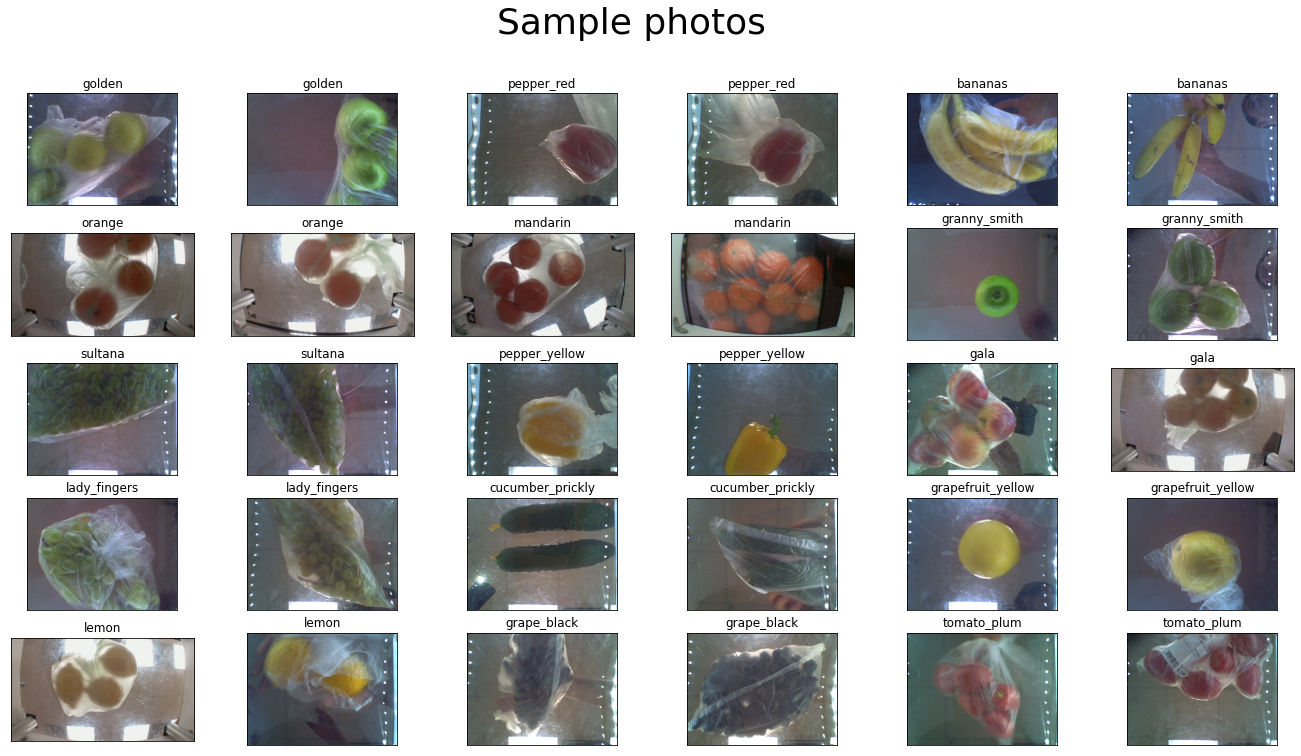

In [7]:
class_list = os.listdir(os.path.join(DIR,DIR_TRAIN))

fig=plt.figure(figsize=(23, 12))
fig.set(facecolor = 'white')
fig.suptitle('Sample photos', fontsize= 36)

columns = 6
rows = 5

for i in range(columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    class_name = class_list[(i)//2]
    plt.imshow(Image.open(os.path.join(DIR,DIR_TRAIN,class_name,os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))[np.random.randint(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))])))
    plt.title(class_name)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [0]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)
class_list = os.listdir(os.path.join(DIR,DIR_TRAIN))
cnt_train_list = []
cnt_val_list = []
cnt_test_list = []

for class_name in class_list:
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for f in os.listdir(os.path.join(DIR,DIR_TRAIN, class_name)):
    if (np.random.randint(1, 11) == 1):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))
  cnt_train_list.append(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))
  cnt_val_list.append(len(os.listdir(os.path.join(DIR,DIR_VAL, class_name))))
  cnt_test_list.append(len(os.listdir(os.path.join(DIR,DIR_TEST, class_name))))
  
df = pd.DataFrame({'CLASS':class_list, 'CNT_TRAIN':cnt_train_list, 'CNT_VAL':cnt_val_list, 'CNT_TEST':cnt_test_list})
df['CNT_ALL'] = df.sum(axis=1)
del class_list, cnt_train_list, cnt_val_list, cnt_test_list

In [9]:
print('Number of photos of each class:')
df

Number of photos of each class:


,CLASS,CNT_TRAIN,CNT_VAL,CNT_TEST,CNT_ALL
0,golden,256,29,9,294
1,pepper_red,117,11,9,137
2,bananas,632,75,9,716
3,orange,56,6,9,71
4,mandarin,118,10,9,137
5,granny_smith,398,41,9,448
6,sultana,476,73,9,558
7,pepper_yellow,155,19,9,183
8,gala,519,72,9,600
9,lady_fingers,162,17,9,188


In [10]:
print('Statistics on the distribution of the number of photos between classes:')
df.describe()

Statistics on the distribution of the number of photos between classes:


,CNT_TRAIN,CNT_VAL,CNT_TEST,CNT_ALL
count,15.00,15.00,15.0,15.00
mean,337.60,39.60,9.0,386.20
std,216.34,27.36,0.0,242.89
min,56.00,6.00,9.0,71.00
25%,158.50,18.00,9.0,185.50
50%,256.00,29.00,9.0,294.00
75%,511.00,70.50,9.0,582.00
max,684.00,78.00,9.0,762.00


In [0]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(0.5,0.5,0.5),
    transforms.RandomRotation(degrees=90),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


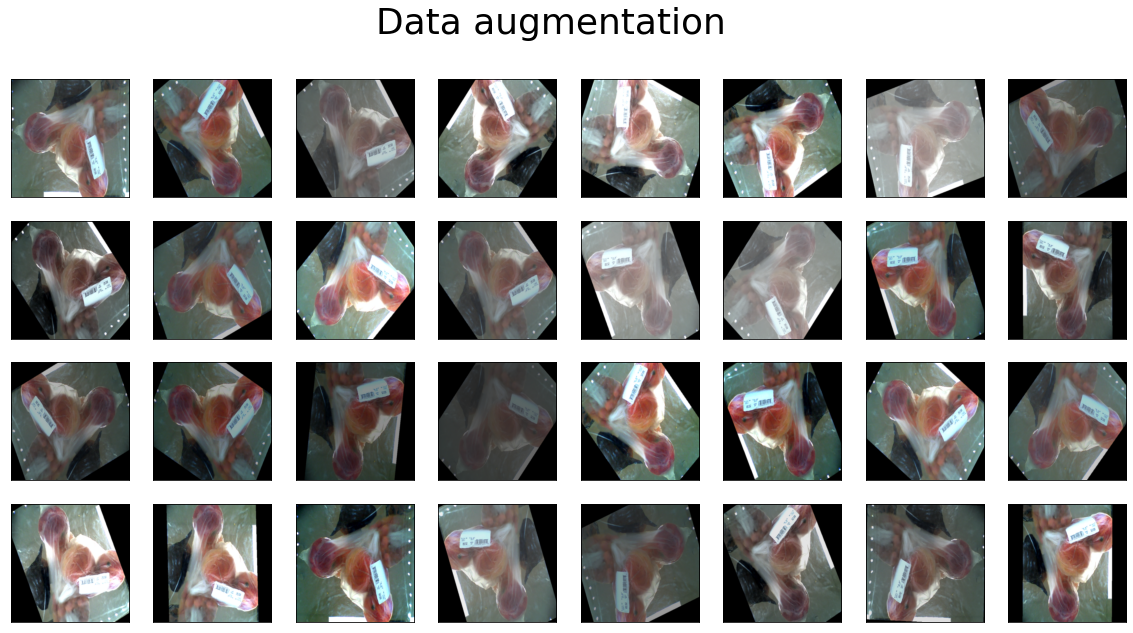

In [12]:
fig=plt.figure(figsize=(20, 10))
fig.set(facecolor = 'white')
fig.suptitle('Data augmentation', fontsize= 36)

columns = 8
rows = 4
class_name = df['CLASS'][np.random.randint(df.shape[0])]
num_photo = np.random.randint(len(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))))
img = Image.open(os.path.join(DIR,DIR_TRAIN,class_name,os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))[num_photo]))

for i in range(columns * rows):
    fig.add_subplot(rows, columns, i + 1)
    if (i == 0):
      plt.imshow((val_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    else:
      plt.imshow((train_transforms(img).permute(1, 2, 0).numpy() * STD + MEAN).clip(0, 1))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [0]:
def train_model(model, fun_loss, optimizer, scheduler, cnt_epochs, hist = None):
  """Model training

  Keyword arguments:
  model -- model based on neural networks
  fun_loss -- loss function
  optimizer -- optimizer that updates the parameters based on the calculated gradients
  scheduler -- scheduler provides method to adjust the learning rate
  cnt_epochs -- number of epochs
  hist -- history from past training

  """
  if (hist == None):
    hist = {'Epochs': [], 'Train loss': [],'Train F1': [],'Val loss': [],'Val F1': []}
    start_epoch = 1
  else:
    start_epoch = hist['Epochs'][-1]+1
  type_trains = ['Train','Val']
  for epoch in range(start_epoch, start_epoch+cnt_epochs):
    for id_type_train in range(2):
      loss = 0.
      preds_class_all = torch.tensor([], dtype=int)
      labels_all = torch.tensor([], dtype=int)
      if (id_type_train == 0):
        model.train()
        dataloader = train_dataloader
      else:
        model.eval()
        dataloader = val_dataloader
      for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(id_type_train == 0):
          preds = model(inputs)
          loss_batch = fun_loss(preds, labels)
          preds_class = preds.argmax(dim=1)
          if (id_type_train == 0):
            loss_batch.backward()
            optimizer.step()
          loss += loss_batch.item()
          preds_class_all = torch.cat([preds_class_all, preds_class.cpu()])
          labels_all = torch.cat([labels_all, labels.data.cpu()])
      
      loss /= len(dataloader)
      if (id_type_train == 0):
        scheduler.step(loss)
        hist['Epochs'].append(epoch)  
      hist[f'{type_trains[id_type_train]} loss'].append(loss)
      hist[f'{type_trains[id_type_train]} F1'].append(f1_score(labels_all, preds_class_all, average='macro'))
        
    print(f"Epoch {epoch}/{start_epoch+cnt_epochs-1}: Train: Loss: {hist['Train loss'][-1]:.4f}, F1 score: {hist['Train F1'][-1]:.4f}   Val: Loss: {hist['Val loss'][-1]:.4f}, F1 score: {hist['Val F1'][-1]:.4f}")
  return model, hist

For clustering, we will use the efficientnet-b4 model and train it on 10 epochs.

In [14]:
model = EfficientNet.from_pretrained("efficientnet-b4", num_classes = len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

cl_cnt = dict(df[['CLASS','CNT_TRAIN']].values)
cl_weight = max([cnt for cnt in cl_cnt.values()]) / torch.tensor([cl_cnt[cl] for cl in train_dataset.classes], dtype=float, device=device)

loss = torch.nn.CrossEntropyLoss(weight=cl_weight.float())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,  amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.3, patience=3, threshold= 0.01, verbose=True)

Loaded pretrained weights for efficientnet-b4


In [15]:
model, hist = train_model(model, loss, optimizer, scheduler, cnt_epochs=10)

Epoch 1/10: Train: Loss: 1.5848, F1 score: 0.5799   Val: Loss: 0.4181, F1 score: 0.8960
Epoch 2/10: Train: Loss: 0.2473, F1 score: 0.9148   Val: Loss: 0.0870, F1 score: 0.9710
Epoch 3/10: Train: Loss: 0.1246, F1 score: 0.9564   Val: Loss: 0.1096, F1 score: 0.9474
Epoch 4/10: Train: Loss: 0.0913, F1 score: 0.9634   Val: Loss: 0.0356, F1 score: 0.9700
Epoch 5/10: Train: Loss: 0.0685, F1 score: 0.9787   Val: Loss: 0.0381, F1 score: 0.9841
Epoch 6/10: Train: Loss: 0.0482, F1 score: 0.9825   Val: Loss: 0.0185, F1 score: 0.9933
Epoch 7/10: Train: Loss: 0.0394, F1 score: 0.9841   Val: Loss: 0.0506, F1 score: 0.9697
Epoch 8/10: Train: Loss: 0.0345, F1 score: 0.9876   Val: Loss: 0.0263, F1 score: 0.9779
Epoch 9/10: Train: Loss: 0.0274, F1 score: 0.9891   Val: Loss: 0.0095, F1 score: 0.9964
Epoch 10/10: Train: Loss: 0.0236, F1 score: 0.9922   Val: Loss: 0.0061, F1 score: 1.0000


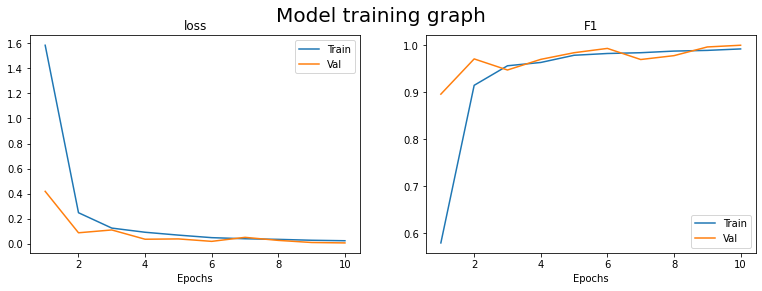

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.set(facecolor = 'white')
fig.suptitle('Model training graph', fontsize= 20)

funs = ['loss','F1']
type_trains = ['Train','Val']

for fun in funs:
  for type_train in type_trains:
    axes[funs.index(fun)].plot(hist['Epochs'], hist[f'{type_train} {fun}'], label=type_train)
  axes[funs.index(fun)].set_title(fun)
  axes[funs.index(fun)].set_xlabel('Epochs')
  axes[funs.index(fun)].legend()
plt.show()

In [17]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model.eval()
preds_class_all = []
labels_all =  []
preds_all = np.array([])

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        preds_class_all = preds_class_all + preds_class.cpu().tolist()
        labels_all = labels_all + labels.data.cpu().tolist()
        if (preds_all.shape[0] == 0):
          preds_all = np.array(preds.cpu().data)
        else:
          preds_all = np.concatenate([preds_all, np.array(preds.cpu().data)])

del inputs, labels
print('The quality of clustering on the test data:')
print(classification_report(labels_all, preds_class_all, target_names = train_dataset.classes))

The quality of clustering on the test data:
                   precision    recall  f1-score   support

          bananas       1.00      1.00      1.00         9
 cucumber_prickly       1.00      1.00      1.00         9
             gala       1.00      1.00      1.00         9
           golden       1.00      1.00      1.00         9
     granny_smith       1.00      1.00      1.00         9
      grape_black       1.00      1.00      1.00         9
grapefruit_yellow       0.82      1.00      0.90         9
     lady_fingers       1.00      1.00      1.00         9
            lemon       1.00      0.44      0.62         9
         mandarin       1.00      1.00      1.00         9
           orange       1.00      1.00      1.00         9
       pepper_red       1.00      1.00      1.00         9
    pepper_yellow       0.75      1.00      0.86         9
          sultana       1.00      1.00      1.00         9
      tomato_plum       1.00      1.00      1.00         9

         a

#Now let's try to visualize the important features that the model found.

Implementation of Saliency Maps from the [article](https://arxiv.org/abs/1312.6034)

In [0]:
def get_saliency_img(model, img, class_id):
  img = img.view([1] + list(img.size()))
  img.requires_grad = True
  optimizer = torch.optim.Adam([img], lr=1.0e-1)
  optimizer.zero_grad()
  loss_value = loss(model(img), torch.tensor([class_id]).to(device))
  loss_value.backward()
  img = img.grad.abs().sum(dim=(0,1)).cpu()
  img = img - img.median()
  img = img.data.relu()
  return img.cpu().numpy()

Function for visualization through [Occlusion](https://arxiv.org/abs/1311.2901)

In [0]:
def get_occlusion_img(model, img, class_id, batch_size = 32, size_square = 20, size_step = 5):
  img = img.view([1] + list(img.size()))
  len_row = img.size()[2] // size_step
  len_col = img.size()[3] // size_step
  confidence_predict = []
  i = 0
  j = 0

  for num_batcn in range(1, (len_row * len_col) // batch_size + 2):
    cnt_img = max(0, batch_size - max(0,num_batcn * batch_size - (len_row * len_col)))
    imgs = torch.cat([img for i in range(cnt_img)])  
    for num_img in range(cnt_img):
      imgs[num_img, :, i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] *= 0
      j += 1
      if (j == len_col):
        i += 1
        j = 0 
    confidence_predict = np.concatenate([confidence_predict ,list(torch.nn.functional.softmax(model(imgs).data ,dim=1)[:,class_id].cpu().numpy())])

  img_cnt = torch.zeros(img.size()[2:])
  img = torch.zeros(img.size()[2:])

  for i in range(len_row):
    for j in range(len_col):
      img[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += confidence_predict[i*len_row+j]
      img_cnt[i*size_step:i*size_step+size_square, j*size_step:j*size_step+size_square] += 1

  img /= img_cnt
  
  return img.cpu().numpy()

In [0]:
def get_original_img(img):
  return STD * (img.cpu().permute(1, 2, 0).numpy()) + MEAN

The results of Saliency and Occlusion

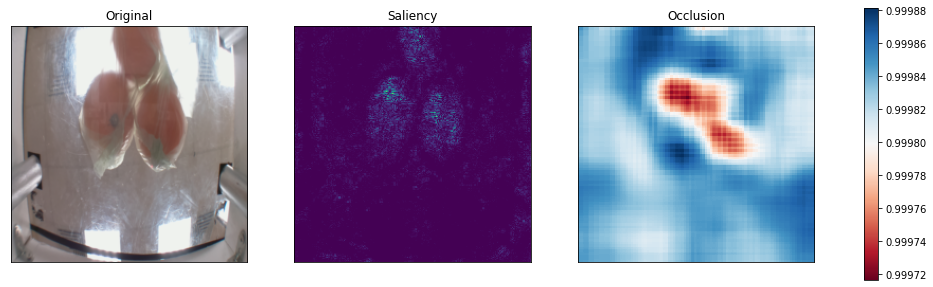

In [21]:
num_photo = 98
img = test_dataloader.dataset[num_photo][0].to(device)
class_id = test_dataloader.dataset[num_photo][1]

img_original = get_original_img(img)
img_saliency = get_saliency_img(model, img, class_id)
img_occlusion = get_occlusion_img(model, img, class_id, batch_size = 15, size_square = 32, size_step = 5)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.set(facecolor = 'white')
axes[0].imshow(img_original.clip(0, 1))
axes[0].set(title = 'Original', xticks=[], yticks=[])
axes[1].imshow(img_saliency.clip(0, 1))
axes[1].set(title = 'Saliency', xticks=[], yticks=[])
im = axes[2].imshow(img_occlusion.clip(0, 1), cmap='RdBu')
axes[2].set(title = 'Occlusion', xticks=[], yticks=[])
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

We visualize the location of the original images and embeddings in two-dimensional space using the t-SNE algorithm.

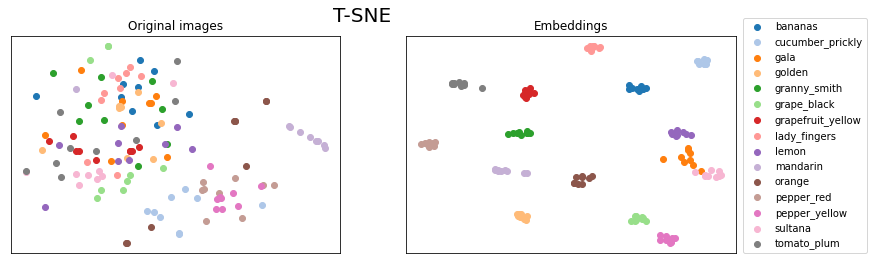

In [22]:
tsne = TSNE(n_jobs=-1,random_state=42)

photos = []
labels_all = []

for class_name in os.listdir(os.path.join(DIR,DIR_TEST)):
  for file_name in os.listdir(os.path.join(DIR,DIR_TEST, class_name)):
    photos.append(np.array(val_transforms(Image.open(os.path.join(DIR,DIR_TEST,class_name,file_name))).view(-1)))
    labels_all.append(class_name)

photos = np.array(photos)

tsne_rep_photos = tsne.fit_transform(photos)
tsne_rep_preds = tsne.fit_transform(preds_all)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
fig.set(facecolor = 'white')
fig.suptitle('T-SNE', fontsize= 20)
colors = plt.cm.get_cmap('tab20')

for i, class_name in enumerate(train_dataset.classes):
  class_filter = [class_name == label for label in labels_all]
  axes[0].scatter(x=tsne_rep_photos[class_filter, 0], y=tsne_rep_photos[class_filter, 1], color=colors.colors[i], label=class_name)

  axes[1].scatter(x=tsne_rep_preds[class_filter, 0], y=tsne_rep_preds[class_filter, 1], color=colors.colors[i], label=class_name)

axes[0].set(title = 'Original images', xticks=[], yticks=[])
axes[1].set(title = 'Embeddings', xticks=[], yticks=[])

axes[1].legend(loc = (1.02, 0))
plt.show()